In [1]:
import pandas as pd
from tqdm import tqdm

train_df, val_df, test_df = pd.read_csv("train.csv"), pd.read_csv("val.csv"), pd.read_csv("test.csv")
train_df[["website", "content", "description"]].head()

,website,content,description
0,https://indiaproperty.com,Find real estate property in India for Buy/Sel...,IndiaProperty.com provides in-depth informatio...
1,https://avaligntech.com,Our premium implants and instruments for ortho...,Provider of outsourced services to medical dev...
2,https://blueconstruction.com,"Blue & Associates, Inc. has been recognized as...","Blue & Associates constructs restaurants, medi..."
3,https://digiowner.com,...,DigiOwner is a commercial and residential prop...
4,https://smiths.com,We’re proud of our 170 year history of being p...,Smiths Group is a British multinational divers...


In [2]:
import nltk
from transformers.utils import is_offline_mode
from filelock import FileLock
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    if is_offline_mode():
        raise LookupError(
            "Offline mode: run this script without TRANSFORMERS_OFFLINE first to download nltk data files"
        )
    with FileLock(".lock") as lock:
        nltk.download("punkt", quiet=True)
        
def preprocess_text(text):
    def clean_html(html):
        soup = BeautifulSoup(html, "html.parser")
        for data in soup(['style', 'script', 'code', 'a']):
            data.decompose()
        return ' '.join(soup.stripped_strings)

    processed_text = str(text).strip()
    # clean html
    processed_text = clean_html(processed_text)
    # remove text between { and }
    processed_text = re.sub(r"\{.*?\}", "", processed_text)
    # remove text between [ and ]
    processed_text = re.sub(r"\[.*?\]", "", processed_text)
    # remove repeated punctuation
    def remove_repeated_punctuation(text):
        return re.sub(r"([,!?!\"#$%&\'\(\)*+,-./:;<=>?@\[\\\]^_`\{|\}~])\1+", r"\1", text)
    
    # tokenize
    processed_text = word_tokenize(processed_text)
    processed_text = ' '.join(processed_text)
    # remove non-ascii characters
    processed_text = re.sub(r'[^\x00-\x7F]+', ' ', processed_text)
    # remove duplicate punctuation
    processed_text = re.sub(r'([!?,.()])\1+', r'\1', processed_text)
    # remove spaces before punctuation
    processed_text = re.sub(r'\s+([!?,.()])', r'\1', processed_text)
    # remove spaces
    processed_text = " ".join(processed_text.split())
    # remove all single characters
    processed_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_text)
    # Remove single characters from the start
    processed_text = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_text)
    # Substituting multiple spaces with single space
    processed_text = re.sub(r'\s+', ' ', processed_text)
    # Removing prefixed 'b'
    processed_text = re.sub(r'^b\s+', '', processed_text)
    # Lemmatization
    processed_text = processed_text.split()
    lemmatizer = WordNetLemmatizer()
    processed_text = [lemmatizer.lemmatize(word) for word in processed_text]
    processed_text = ' '.join(processed_text)
    processed_text = remove_repeated_punctuation(processed_text)
    processed_text = " ".join(processed_text.split())

    return processed_text

In [11]:
def print_idx(df, idx):
    print("------ Website:", df.iloc[idx]["website"])
    print("------ Content:", df.iloc[idx]["content"])
    print("------ Description:", df.iloc[idx]["description"])

In [4]:
def num_words_description_contained_content(description, content):
    description = set(description.split())
    content = set(content.split())
    return len(description & content)

In [23]:
def process_csv_data(df):
    df["content"] = [preprocess_text(x) for x in tqdm(df["content"].values, desc="Process content...")]
    df["num_words_des"] = df["description"].apply(lambda x: len(set(x.split())))
    df["num_words_content"] = df["content"].apply(lambda x: len(set(x.split())))
    df["num_words_des_contained_content"] = df.apply(lambda x: num_words_description_contained_content(x["description"], x["content"]), axis=1)
    df = df[df["num_words_des"] < 100]
    df = df[df["num_words_des"] > 5]
    df["ratio"] = df["num_words_des_contained_content"] / df["num_words_des"]
    df = df[df["ratio"] >= 0.45]
    df = df[df["num_words_content"] > df["num_words_des"]]
    df = df.reset_index(drop=True)
    return df

In [6]:
df = process_csv_data(train_df)

  0%|          | 0/107982 [00:00<?, ?it/s]

Process content...


100%|██████████| 107982/107982 [12:01<00:00, 149.60it/s]


Process count number words...


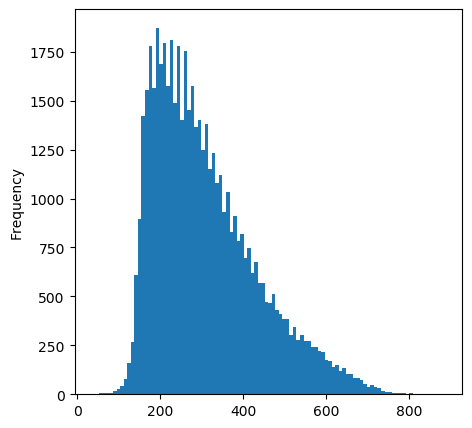

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
df[df["ratio"] >= 0.45].num_words_content.plot.hist(bins=100)
plt.show()

In [22]:
df[df["ratio"] >= 0.45].shape

(53148, 13)

In [21]:
print_idx(df, 10)

------ Website: https://newporthospital.org
------ Content: Newport Hospital Community Lecture Series Registration Providing award-winning health care to patient on Aquidneck Island and beyond Founded in 1873 a 12-bed cottage hospital, Newport Hospital is state-of-the-art, award-winning health care facility that offer wide array of service to the community. In addition to an emergency department that treat patient from Newport and surrounding towns, the hospital provides diagnostic and surgical service and is home to the renowned Vanderbilt Rehabilitation Center and the award-winning Noreen Stonor Drexel Birthing Center. Visiting hour and guideline About Newport Hospital Our center and service Newport Hospital ha continuously maintained Magnet status since 2004. The Magnet designation from the American Nurses Credentialing Center( ANCC) is considered the gold standard for nursing excellence. Of more than 5,000 hospital in the United States, only about 4 percent meet Magnet rigorous sta

In [24]:
tdf = process_csv_data(test_df)
tdf.shape

Process content...: 100%|██████████| 5000/5000 [00:34<00:00, 143.94it/s]


In [27]:
vdf = process_csv_data(val_df)
vdf.shape

Process content...: 100%|██████████| 11998/11998 [01:21<00:00, 147.16it/s]


(5996, 13)

In [30]:
test_df.columns

Index(['company_name', 'website', 'description', 'content', 'about_us_url',
       'about_us_content', 'url', 'source', 'language', 'num_words_des',
       'num_words_content', 'num_words_des_contained_content'],
      dtype='object')